# Querying for indices

This notebook briefly shows how to use Xoak's `query()` method to build more complicated queries.

In [1]:
import numpy as np
import xarray as xr
import xoak

xr.set_options(display_style='text');

## Load example dataset

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")

# create artificial 2d coords
ds.coords["lat2d"], ds.coords["lon2d"] = xr.broadcast(
    ds.coords["lat"], ds.coords["lon"]
)

display(ds)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lat2d    (lat, lon) float32 75.0 75.0 75.0 75.0 75.0 ... 15.0 15.0 15.0 15.0
    lon2d    (lat, lon) float32 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
ds.xoak.set_index(['lat2d', 'lon2d'], 'sklearn_geo_balltree')

## Create trajectory dataset

In [4]:
ds_trajectory = xr.Dataset(
    {
        'latitude': ('along_track', np.linspace(75.0, 15.0, 23)),
        'longitude': ('along_track', np.linspace(200, 330, 23)),
    },
    coords={"along_track": ("along_track", np.arange(23))},
)

ds_trajectory

<xarray.Dataset>
Dimensions:      (along_track: 23)
Coordinates:
  * along_track  (along_track) int64 0 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21 22
Data variables:
    latitude     (along_track) float64 75.0 72.27 69.55 ... 20.45 17.73 15.0
    longitude    (along_track) float64 200.0 205.9 211.8 ... 318.2 324.1 330.0

## Select and check for distances to grid points

In [5]:
# ds.xoak.sel() does the following two steps

indices = ds.xoak.query(
    lat2d=ds_trajectory.latitude,
    lon2d=ds_trajectory.longitude,
)
selected = ds.isel(indices)

display(selected)

<xarray.Dataset>
Dimensions:  (along_track: 23, time: 2920)
Coordinates:
    lat      (along_track) float32 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
    lon      (along_track) float32 200.0 205.0 212.5 217.5 ... 317.5 325.0 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lat2d    (along_track) float32 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
    lon2d    (along_track) float32 200.0 205.0 212.5 217.5 ... 317.5 325.0 330.0
Dimensions without coordinates: along_track
Data variables:
    air      (time, along_track) float32 241.2 244.7 244.4 ... 296.7 295.7 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [6]:
selected.coords["along_track"] = ds_trajectory.coords["along_track"]

## We can now easily calculated the mismatch

In [7]:
selected["diff_lat"] = ds_trajectory["latitude"] - selected["lat"]
selected["diff_lon"] = ds_trajectory["longitude"] - selected["lon"]

In [8]:
display(selected)

<xarray.Dataset>
Dimensions:      (along_track: 23, time: 2920)
Coordinates:
    lat          (along_track) float32 75.0 72.5 70.0 67.5 ... 20.0 17.5 15.0
    lon          (along_track) float32 200.0 205.0 212.5 ... 317.5 325.0 330.0
  * time         (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lat2d        (along_track) float32 75.0 72.5 70.0 67.5 ... 20.0 17.5 15.0
    lon2d        (along_track) float32 200.0 205.0 212.5 ... 317.5 325.0 330.0
  * along_track  (along_track) int64 0 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21 22
Data variables:
    air          (time, along_track) float32 241.2 244.7 244.4 ... 295.7 295.7
    diff_lat     (along_track) float64 0.0 -0.2273 -0.4545 ... 0.4545 0.2273 0.0
    diff_lon     (along_track) float64 0.0 0.9091 -0.6818 ... 0.6818 -0.9091 0.0
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Visualize

In [9]:
from matplotlib import pyplot as plt

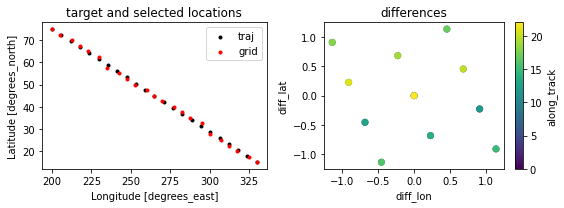

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ds_trajectory.plot.scatter(
    x="longitude", y="latitude", c="k",
    s=9, ax=ax[0], label="traj"
)
selected.plot.scatter(
    x="lon2d", y="lat2d", c="r",
    s=9, ax=ax[0], label="grid"
)
ax[0].legend()
ax[0].set_title("target and selected locations")

selected.plot.scatter(
    x="diff_lon", y="diff_lat", hue="along_track",
    ax=ax[1]
)
ax[1].set_title("differences")

fig.tight_layout();